# Autocorrelation and prediction intervals

## The correlogram

Notes for Open University M249 Time Series book 2 - section 9.1

In [1]:
! python -c 'import datapackage' || pip install datapackage

In [2]:
%matplotlib inline

import datapackage
import pandas as pd

# data licensed for non-commercial use only - https://datahub.io/core/bond-yields-uk-10y
data_url = 'https://datahub.io/core/bond-yields-uk-10y/datapackage.json'

resources = datapackage.Package(data_url).resources

quarterly_csv_url = [pkg for pkg in resources if pkg.name == 'quarterly_csv'][0].descriptor['path']
data = pd.read_csv(quarterly_csv_url)
data = data.set_index('Date', drop=True).asfreq('Q')
data.head()

,Rate
Date,
1984-03-31,10.9817
1984-06-30,11.5721
1984-09-30,11.9866
1984-12-31,11.1937
1985-03-31,11.6959


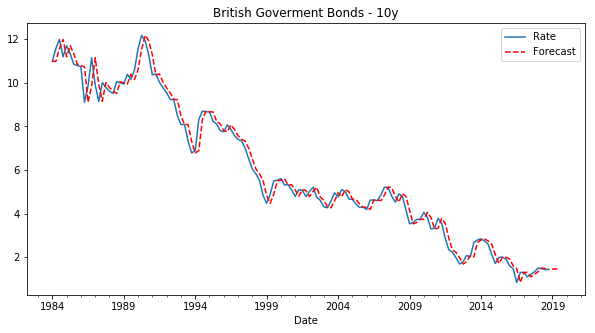

In [3]:
%matplotlib inline

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import SimpleExpSmoothing
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fit = SimpleExpSmoothing(data).fit()
fcast = fit.forecast(3).rename('Forecast')

plt.rcParams["figure.figsize"] = (10,5)

ax = data.plot(legend=True, title='British Goverment Bonds - 10y')
ax.set_xlabel('yield')
_ = fit.fittedvalues.plot(ax=ax, linestyle='--', color='red')   # predicted past
_ = fcast.plot(ax=ax, color='red', linestyle='--', legend=True) # predicted future

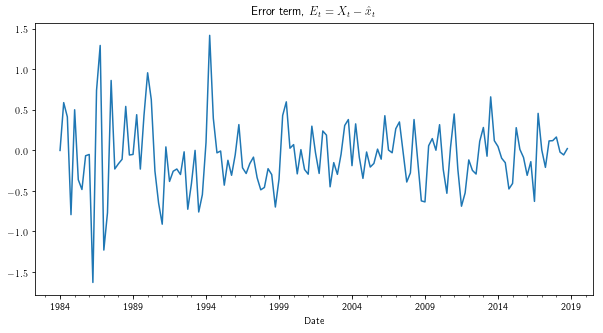

In [4]:
plt.rcParams["figure.figsize"] = (10,5)
plt.rc('text', usetex=True)
data['Errors'] = data['Rate'] - fit.fittedvalues
_ = data['Errors'].plot(title='Error term, $E_t = X_t - \hat{x}_t$')

Errors appear to be distributed around zero with constant(ish) variance.

In [5]:
data['Errors_m1'] = data['Errors'].shift(1)
data['Errors_m2'] = data['Errors'].shift(2)

In [6]:
data.head()

,Rate,Errors,Errors_m1,Errors_m2
Date,,,,
1984-03-31,10.9817,0.0000,NaN,NaN
1984-06-30,11.5721,0.5904,0.0000,NaN
1984-09-30,11.9866,0.4145,0.5904,0.0000
1984-12-31,11.1937,-0.7929,0.4145,0.5904
1985-03-31,11.6959,0.5022,-0.7929,0.4145


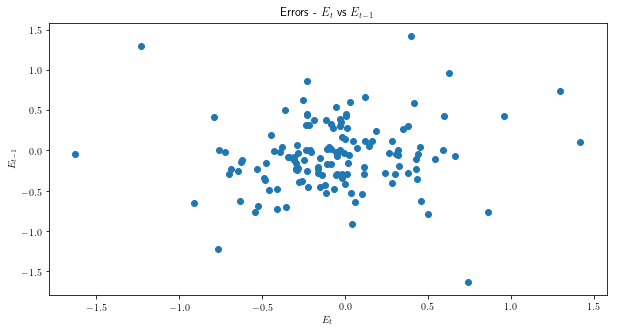

In [7]:
plt.scatter(data['Errors'], data['Errors_m1'])
_ = plt.title("Errors - $E_t$ vs $E_{t-1}$")
_ = plt.xlabel("$E_t$")
_ = plt.ylabel("$E_{t-1}$")

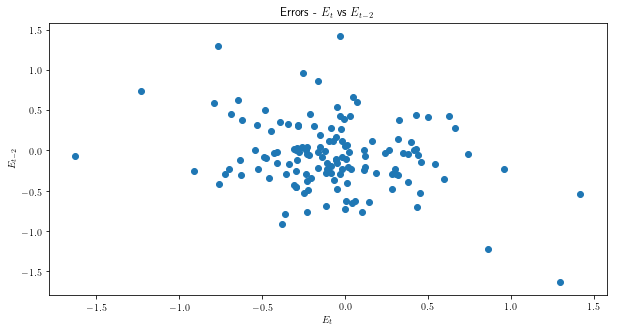

In [8]:
ax = plt.scatter(data['Errors'], data['Errors_m2'])
_ = plt.title("Errors - $E_t$ vs $E_{t-2}$")
_ = plt.xlabel("$E_t$")
_ = plt.ylabel("$E_{t-2}$")

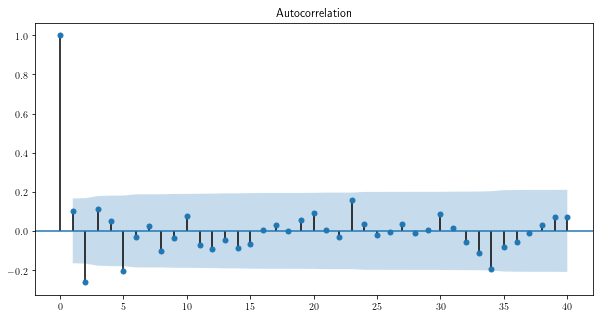

In [9]:
plot_acf(data['Errors'], alpha=0.05, lags=40)
plt.show()

In [10]:
data[['Errors', 'Errors_m1']].corr()

,Errors,Errors_m1
Errors,1.000000,0.099725
Errors_m1,0.099725,1.000000


In [11]:
data[['Errors', 'Errors_m2']].corr()

,Errors,Errors_m2
Errors,1.000000,-0.266207
Errors_m2,-0.266207,1.000000


Nice!  The acf plot and error correlations agree.

**NOTE:** 

 1. A correlation between random variables $E_{t-x}$ and $E_t$ suggest that we could improve the forecast by taking this into account - i.e. the forecast metho used is not the best possible.
 2. At lag zero there is perfect correlation, i.e. $corr(E_t, E_{t-0}) == 1$

## Tests for zero autocorrelation

### Why?

 - evidence of autocorrelation between the 1-step ahead forecast errors $\implies$ forecasting method is not best possible
 
### How?

 - $p_k$ - population autocorrelation between $E_{t-k}$ and $E_t$ 
 - $p_k$ for $k = 1, 2, \dots$ is the AutoCorrelation Function (ACF)
 - $r_k = \hat{p}_k$ is the sample autocorrelation
 - due to RV (even if $p_k = 0$ for $k \geq 1$) it is unlikely $r_k$ will be exactly zero
 - significance test  of null hypotenesis $p_k = 0$ is required to check if reasonable to conclude $p_k = 0$
 - under null hypothesis $p_k = 0$ if 1-step forecast errors have constant variance $\hat{p}_k \approx N(0, \frac{1}{n})$ 
   - null distribution can be used to calculate a $p$ value and test the hypothesis $p_k = 0$ but rarely is used because it is done graphically
 - if null hyp is true, prob of sampe autocorrelation within iternal defined by $\pm 1.96\ / \sqrt{n}$
   - if $r_k$ lies outside interval then the sig. prob of the test is less than 0.05 ($p < 0.05$) $\implies$ autocorrelation at lag k is != zero
 - the values $\pm 1.96\ / \sqrt{n}$ can be shown on the correlogram (see acf_plot above)
 - test of null hyp with several autocorrelations is the Portmanteau test - $Q = N\sum_{j=1}^{k}r^2_j$
   - Many variants available
   - Ljung-Box common variant.  How many legs? 
     - Usually, only the first few lags are of intertest together with the lag corresponding to the season period
     - Stata - `min((len(data['Value'])/2 - 2), 40)` # stata approach - https://stats.stackexchange.com/a/200283/48448
     - [Hyndman](http://robjhyndman.com/hyndsight/ljung-box-test/) recommends min(10, T/5) for non-seasonal time series

In [12]:
# 0.05 confidence interval

(-1.96/np.sqrt(len(data)), 1.96/np.sqrt(len(data)))

(-0.16565023392678924, 0.16565023392678924)

Note that the Errors with lag 2 is bigger than this!

In [13]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lags = min((len(data['Errors'])/2 - 2), 40) # stata approach - https://stats.stackexchange.com/a/200283/48448

result = acorr_ljungbox(data['Errors'], lags=lags)
result

(array([ 1.42168104, 11.44726788, 13.30531434, 13.66519639, 19.89597588,
        20.04801277, 20.15675263, 21.76752219, 21.95993369, 22.81242471,
        23.5910295 , 24.92209014, 25.24499202, 26.51234071, 27.23345504,
        27.238456  , 27.39589469, 27.39703712, 27.92065295, 29.36503271,
        29.36666384, 29.53747519, 33.68380599, 33.89554939, 33.97955346,
        33.98236083, 34.20026207, 34.2257238 , 34.23074065, 35.64868618,
        35.6937052 , 36.3328803 , 38.67932632, 45.79425263, 47.13339236,
        47.72770529, 47.75313703, 47.9084051 , 48.88954644, 49.93728473]),
 array([0.23312691, 0.00326781, 0.00402078, 0.00844396, 0.00130716,
        0.00271542, 0.00524087, 0.00536523, 0.00900683, 0.01146053,
        0.01457201, 0.01519641, 0.02143033, 0.02226233, 0.02689081,
        0.03890764, 0.05251125, 0.07184379, 0.08496762, 0.08081658,
        0.10547316, 0.13014615, 0.06987047, 0.0865426 , 0.10834562,
        0.13546892, 0.1603027 , 0.19353993, 0.23091394, 0.2198041 ,
      

Note the return values from acorr_ljungbox:

```
    lbvalue : float or array
        test statistic
    pvalue : float or array
        p-value based on chi-square distribution
    bpvalue : (optionsal), float or array
        test statistic for Box-Pierce test
    bppvalue : (optional), float or array
        p-value based for Box-Pierce test on chi-square distribution
```

How do I interpret the p vaues for my data? [stackoverflow question](https://stats.stackexchange.com/questions/200267/interpreting-ljung-box-test-results-from-statsmodels-stats-diagnostic-acorr-lju)

OU Guidelines:

| p  <img width=100/>    | Evidence of autocorrelation at lags 1 to k 
| ---------------------- | -----------
| $p > 0.10$             | little      
| $0.10 \geq p > 0.05$   | weak       
| $0.15 \geq p > 0.01$   | moderate     
| $p \leq 0.01$          | strong     

In [14]:
pvalues = result[1]
pvalues <= .01

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

According to this we have strong evidence of autocorrelation.  TODO - confirm these results.

### Hmmm, this looks wrong - verify with R ...

<!-- language: R -->

```
install.packages("jsonlite", repos="https://cran.rstudio.com/")
library("jsonlite")

json_file <- 'https://datahub.io/core/bond-yields-uk-10y/datapackage.json'
json_data <- fromJSON(paste(readLines(json_file), collapse=""))

# get list of all resources:
print(json_data$resources$name)

# print all tabular data(if exists any)
for(i in 1:length(json_data$resources$datahub$type)){
  if(json_data$resources$datahub$type[i]=='derived/csv'){
    path_to_file = json_data$resources$path[i]
    data <- read.csv(url(path_to_file))
    print(data)
  }
}

require(xts)
data.ts = xts(x = data$Rate, order.by = as.POSIXct(data$Year))
checkresiduals(naive(data.ts))
```

Returns:
    
```
	Ljung-Box test

data:  Residuals from Naive method
Q* = 10.442, df = 7, p-value = 0.1649

Model df: 0.   Total lags used: 7
```

---
p values are relatively large - results are not signifcant, i.e. residuals are not distinguishable from white noise

## Prediction intervals for 1-step ahead forecasts

### What are prediction intervals?

1-step ahead forecast is a point estimate
 - it gives a single forecasted value
 - some measure of uncertainty with forecasts
 - measure of uncertainty is **prediction interval**
 
### How?

 - A $100(1 - \alpha)%$ **prediction interval** for $X_{n+1}$ given observed values up to and including $x_n$:
   - is an interval with probability $1 - \alpha$ of containing $X_{n+1}$.

